In [2]:
import json
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Чтение данных из JSON файла
file_path = 'pm_vk_wall.json'  # путь к файлу
with open(file_path, 'r', encoding='utf-8') as f:
    vk_data = json.load(f)

# Создание списка для признаков
posts = []
for post in vk_data:
    # Извлечение нужных полей из постов
    posts.append({
        'likes_count': post.get('likes', {}).get('count', 0),
        'comments_count': post.get('comments', {}).get('count', 0),
        'reposts_count': post.get('reposts', {}).get('count', 0),
        'views_count': post.get('views', {}).get('count', 0),
        'attachments_count': len(post.get('attachments', [])),
        'text_length': len(post.get('text', '')),
        'has_attachments': 1 if post.get('attachments') else 0,
        'platform': post.get('post_source', {}).get('platform', 'unknown'),
        'is_donut': 1 if post.get('donut', {}).get('is_donut', False) else 0,
        'post_date': post.get('date', 0),
    })

# Преобразование данных в DataFrame
df = pd.DataFrame(posts)

# Нормализация числовых признаков (кроме категориальных, таких как платформа)
scaler = StandardScaler()
numerical_features = ['likes_count', 'comments_count', 'reposts_count', 'views_count', 'attachments_count', 'text_length', 'post_date']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Отображение первых строк DataFrame
df.head()


,likes_count,comments_count,reposts_count,views_count,attachments_count,text_length,has_attachments,platform,is_donut,post_date
0,2.437374,0.489365,1.150825,0.937108,0.578613,-0.265111,1,iphone,0,1.141870
1,-0.907849,-0.238972,-0.134222,-0.476778,-0.201339,-0.274706,1,iphone,0,1.246122
2,-0.976119,-0.238972,-0.209813,-0.489247,-0.201339,0.028498,1,iphone,0,1.245750
3,-0.703040,-0.238972,0.092551,-0.378408,-0.201339,0.253023,1,iphone,0,1.245626
4,-0.634770,-0.238972,-0.209813,-0.272419,6.038279,-0.267030,1,iphone,0,1.236869


## Задание 2

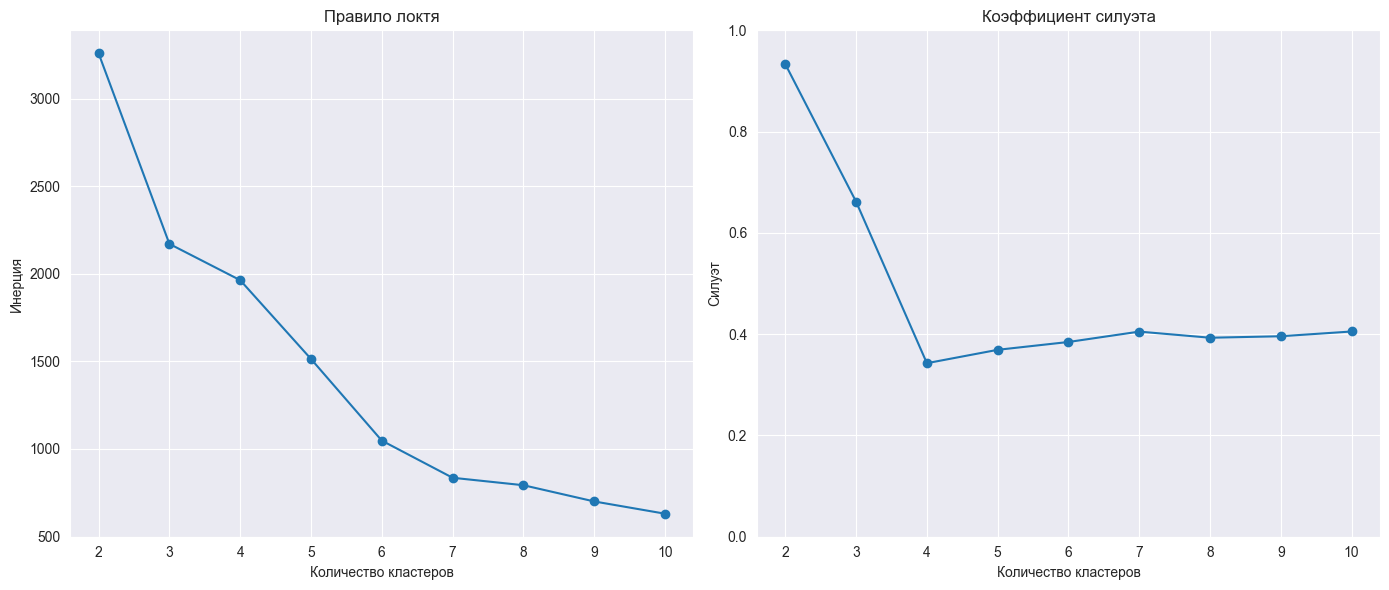

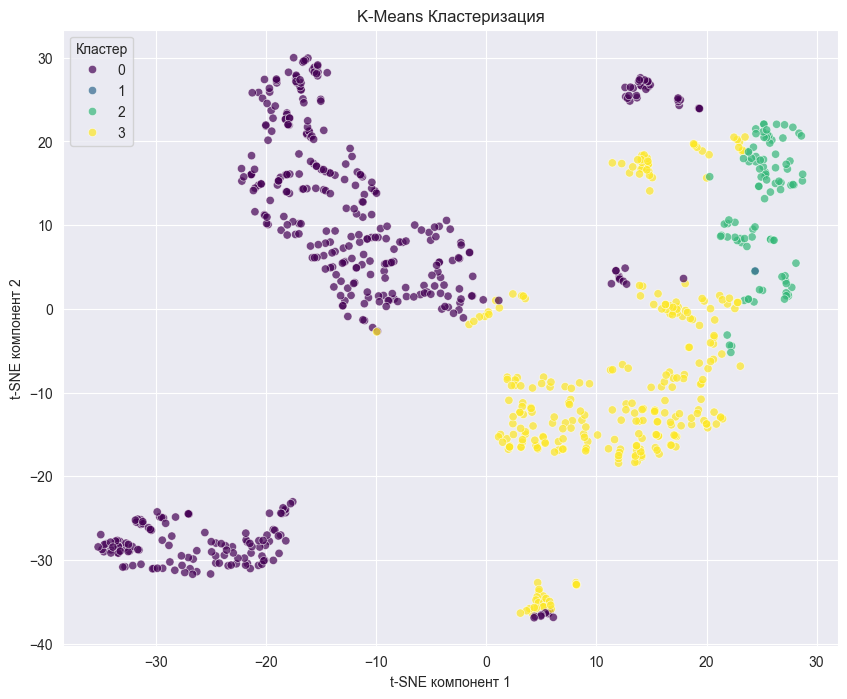

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Выбор признаков для кластеризации
features = df[['likes_count', 'comments_count', 'reposts_count', 'views_count', 'attachments_count']]

# Определение диапазона для количества кластеров
range_n_clusters = range(2, 11)

# Инициализация списков для хранения результатов
inertia = []
silhouette_scores = []

# Поиск оптимального количества кластеров
for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features)
    
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features, kmeans.labels_))

# Построение графика "правило локтя"
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, inertia, marker='o')
plt.title('Правило локтя')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')

# Построение графика коэффициента силуэта
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Коэффициент силуэта')
plt.xlabel('Количество кластеров')
plt.ylabel('Силуэт')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Обозначим оптимальное количество кластеров (например, 4, если это так по графикам)
optimal_n_clusters = 4

# Проведем кластеризацию с оптимальным количеством кластеров
kmeans = KMeans(n_clusters=optimal_n_clusters, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(features)

# Визуализация кластеров с использованием t-SNE
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)

# Добавим результаты t-SNE в DataFrame
df['tsne_x'] = tsne_results[:, 0]
df['tsne_y'] = tsne_results[:, 1]

# Построение графика кластеров
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_x', y='tsne_y', hue='kmeans_cluster', palette='viridis', data=df, legend='full', alpha=0.7)
plt.title('K-Means Кластеризация')
plt.xlabel('t-SNE компонент 1')
plt.ylabel('t-SNE компонент 2')
plt.legend(title='Кластер')
plt.show()


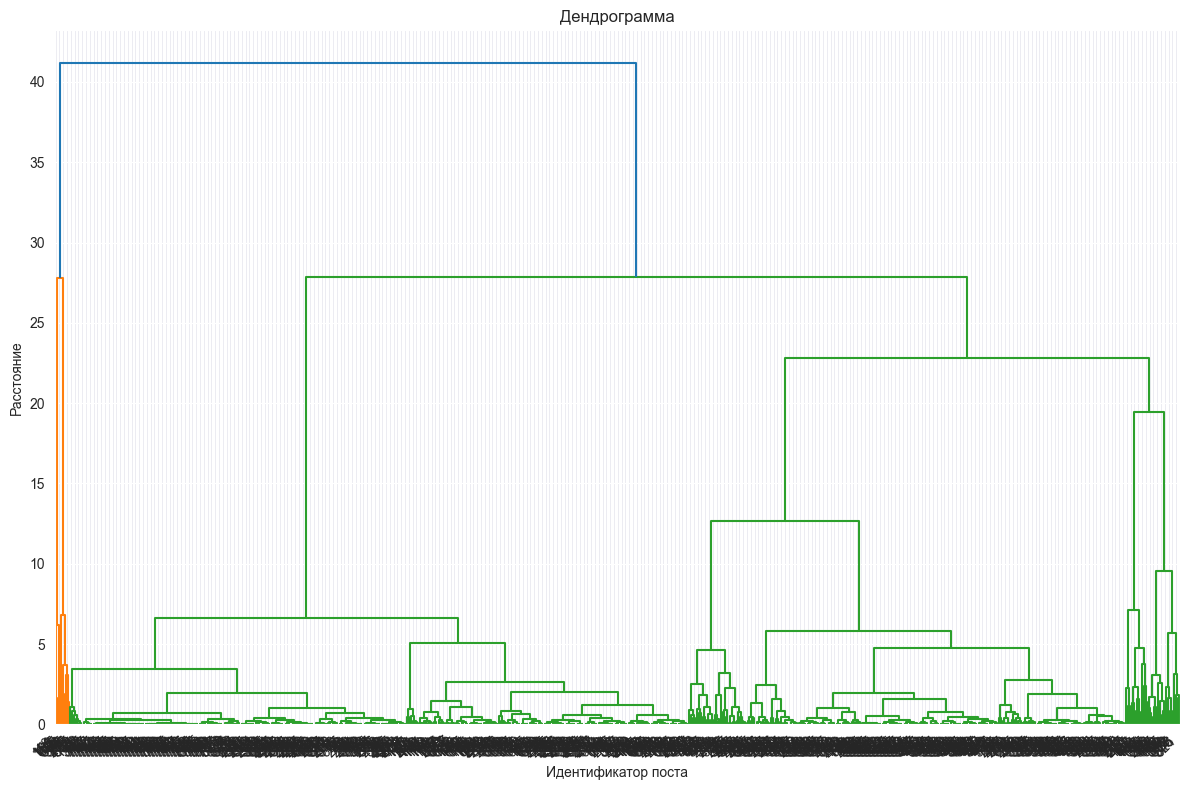

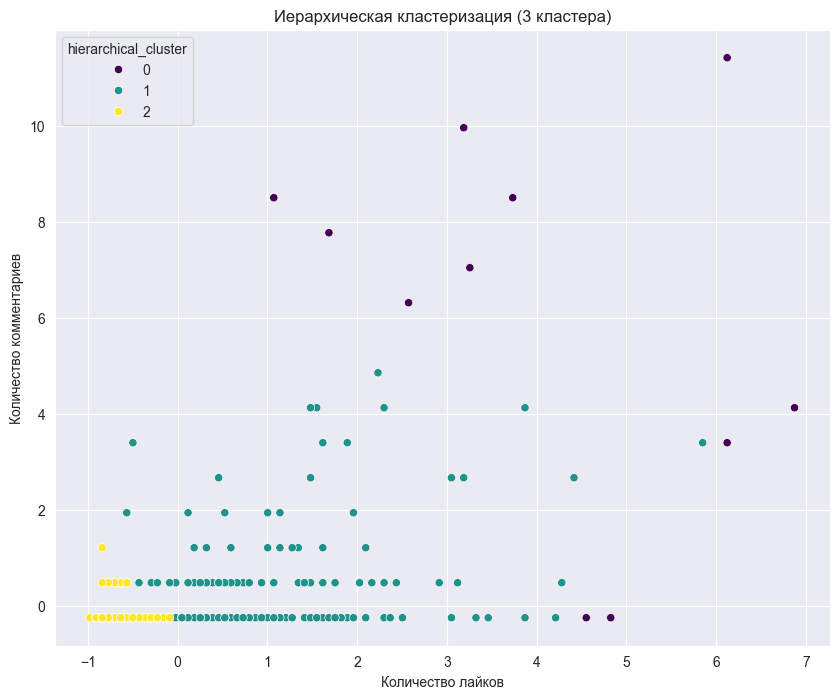

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Предположим, что df — это ваш датафрейм с нормализованными данными
# Подбираем нужные столбцы для иерархической кластеризации
X = df[['likes_count', 'comments_count', 'views_count']]

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage

# Данные иерархической кластеризации
Z = linkage(X, method='ward')

plt.figure(figsize=(12, 8))
dendrogram(Z, leaf_rotation=90, leaf_font_size=10)
plt.title('Дендрограмма')
plt.xlabel('Идентификатор поста')
plt.ylabel('Расстояние')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()  # Подгонка элементов графика
plt.show()

# Обработка кластеров
hierarchical_cluster = AgglomerativeClustering(n_clusters=3)
df['hierarchical_cluster'] = hierarchical_cluster.fit_predict(X)

# Визуализация кластеров
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X['likes_count'], y=X['comments_count'], hue=df['hierarchical_cluster'], palette='viridis', legend='full')
plt.title('Иерархическая кластеризация (3 кластера)')
plt.xlabel('Количество лайков')
plt.ylabel('Количество комментариев')
plt.show()